The Cal_deviation function identifies anomaly in the bond trading price, and making a PDF file containg the reference YTM curve structure as well as the deviated bond's trading price and valuation price.

We can classify anomaly into four categories:
#1. trading price is outside +/- n_1 basis points range of valuation price 
#2. trading price is outside +/- n_2 basis points range of reference price
#3. trading price is within +/- min(n_1,n_2) range of both 
#4. trading price is outside the rational range of >= shorter terms bond trading price, and <= longer terms bond trading price


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
%matplotlib inline



basestation = "C:\\Users\\tony\\Desktop\\calculate yield curve"
#read bond description
df_bond_info = pd.read_excel("C:\\Users\\tony\\Desktop\\calculate yield curve\\China_bond_market_data(python readable).xlsx",sheetname= "Bond_price")
df_bond_info = df_bond_info.iloc[[0,1,2,3,4,5],:]
#read bond price
df_bond_price = pd.read_excel("C:\\Users\\tony\\Desktop\\calculate yield curve\\China_bond_market_data(python readable).xlsx",sheetname= "Bond_price",skiprows = [1,2,3,4,5,6])  #,na_values = 0)
#read bond valuation
df_bond_valuation = pd.read_excel("C:\\Users\\tony\\Desktop\\calculate yield curve\\China_bond_market_data(python readable).xlsx",sheetname= "Bond_valuation",skiprows = [1,2,3,4,5,6]) #,na_values = 0)
#read bond trading volume
df_bond_volume = pd.read_excel("C:\\Users\\tony\\Desktop\\calculate yield curve\\China_bond_market_data(python readable).xlsx",sheetname= "Bond_volume",skiprows = [1,2,3,4,5,6]) #,na_values = 0)
#read bond deal number
df_bond_deal = pd.read_excel("C:\\Users\\tony\\Desktop\\calculate yield curve\\China_bond_market_data(python readable).xlsx",sheetname= "Bond_deal",skiprows = [1,2,3,4,5,6]) #,na_values = 0)
#read CGB 中债指数
df_CGB = pd.read_excel("C:\\Users\\tony\\Desktop\\calculate yield curve\\China_bond_market_data(python readable).xlsx",sheetname= "CGB",skiprows = [0,2])
#read CDB 中债指数
df_CDB = pd.read_excel("C:\\Users\\tony\\Desktop\\calculate yield curve\\China_bond_market_data(python readable).xlsx",sheetname= "CDB",skiprows = [0,2])
#read EXIMCH 中债指数
df_EXIMCH = pd.read_excel("C:\\Users\\tony\\Desktop\\calculate yield curve\\China_bond_market_data(python readable).xlsx",sheetname= "EXMICH",skiprows = [0,2])
#read ADBCH 中债指数
df_ADBCH = pd.read_excel("C:\\Users\\tony\\Desktop\\calculate yield curve\\China_bond_market_data(python readable).xlsx",sheetname= "ADBCH",skiprows = [0,2])

c:\users\tony\python 3.7.1\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [2]:
#convert missing value in df_bond_price& df_bond_valuation& df_bond_volume& df_bond_deal
df_bond_valuation.iloc[:,1:len(df_bond_valuation.iloc[0,:])]= df_bond_valuation.iloc[:,1:len(df_bond_valuation.iloc[0,:])].fillna(0)
df_bond_price.iloc[:,1:len(df_bond_price.iloc[0,:])] = df_bond_price.iloc[:,1:len(df_bond_price.iloc[0,:])].fillna(0)
df_bond_volume.iloc[:,1:len(df_bond_volume.iloc[0,:])] = df_bond_volume.iloc[:,1:len(df_bond_volume.iloc[0,:])].fillna(0)
df_bond_deal.iloc[:,1:len(df_bond_deal.iloc[0,:])] =df_bond_deal.iloc[:,1:len(df_bond_deal.iloc[0,:])].fillna(0)

#convert all column names back to string.
for i in range(0,len(df_bond_price.columns.values)):
    df_bond_price.columns.values[i] = str(df_bond_price.columns[i])
    df_bond_valuation.columns.values[i]=str(df_bond_valuation.columns[i])
    df_bond_volume.columns.values[i]=str(df_bond_volume.columns[i])
    df_bond_deal.columns.values[i]=str(df_bond_deal.columns[i])
    
#convert to date format
df_bond_valuation["ID_CHINA_INTERBANK"] = pd.to_datetime(df_bond_valuation["ID_CHINA_INTERBANK"])
df_bond_price["ID_CHINA_INTERBANK"] = pd.to_datetime(df_bond_price["ID_CHINA_INTERBANK"])
df_bond_volume["ID_CHINA_INTERBANK"] = pd.to_datetime(df_bond_volume["ID_CHINA_INTERBANK"])
df_bond_deal["ID_CHINA_INTERBANK"] = pd.to_datetime(df_bond_deal["ID_CHINA_INTERBANK"])
df_bond_price.dtypes
#
df_CGB["期限"] = pd.to_datetime(df_CGB["期限"])
df_CDB["期限"] = pd.to_datetime(df_CDB["期限"])
df_EXIMCH["期限"] = pd.to_datetime(df_EXIMCH["期限"])
df_ADBCH["期限"] = pd.to_datetime(df_ADBCH["期限"])



#df_bond_valuation
#df_CDB.drop(index = [0,1])
#df_CDB
#df_bond_info
a = df_bond_info.iloc[0,1]
a[0:len(a)-3]

#df_bond_price[float(a[0:len(a)-3])]
df_bond_info
#df_CDB["1Y"]

#v= df_CDB[['1M','2M']]
#max(v.iloc[1,:])
#print(type(130402))
#df_bond_price.iloc[:,0][0]\
#df_bond_price
df_bond_price.head()

,ID_CHINA_INTERBANK,130402,150407,130404,100403,180405,170407,150410,150415,170411,...,150305,150308,150314,160303,160310,170303,180310,180321,180322,150319
0,2017-03-15,3.984823,3.842600,3.828996,3.835140,0.0,0.0,3.598728,3.997745,0.0,...,4.0678,4.2309,4.2917,4.2194,4.2200,0.000000,0.0,0.0,0.0,4.290000
1,2017-03-16,3.984650,3.842332,3.828828,3.835363,0.0,0.0,3.598497,3.998005,0.0,...,4.2734,4.4355,4.1994,4.3799,4.1750,0.000000,0.0,0.0,0.0,4.290046
2,2017-03-17,3.984478,3.842107,3.828660,3.835586,0.0,0.0,3.598266,3.998266,0.0,...,3.9838,3.9693,4.1880,3.9773,4.1800,0.000000,0.0,0.0,0.0,4.290074
3,2017-03-20,3.983961,3.841429,3.828158,3.836260,0.0,0.0,3.597573,3.999055,0.0,...,4.2265,4.3546,4.2049,4.2000,4.1794,4.110000,0.0,0.0,0.0,4.370000
4,2017-03-21,3.983789,3.841203,3.827991,3.836487,0.0,0.0,3.980000,3.999320,0.0,...,4.4750,3.9869,4.3520,4.0100,4.2205,4.109972,0.0,0.0,0.0,4.380000


In [3]:

l = [130402,180210]
#a = df_bond_price.iloc[3,:]['130402']
a
#bond_datetime_list= list(df_bond_valuation.iloc[:,0])
#bond_datetime_list[0:10]
#str(np.datetime64(datetime.datetime(2017,3,27,0,0)))[0:10]
#index = bond_datetime_list.index(str(np.datetime64(datetime.datetime(2017,4,17,0,0)))[0:10])
#df_bond_price.iloc[3,:].iloc[21]

#df_bond_price.loc['130404']
#df_bond_price.columns.values

'130402.IB'

In [56]:
#helper function to narrow date
def select_date(df,start_date_time):
     dt = np.datetime64(start_date_time)
     df = df[df.iloc[:,0] >=dt]
     return df

#helper function to target date
def retrieve_target_date_df(df,target_date):
    df = df[df.iloc[:,0] == target_date]
    return df
    
#helper function to select which reference rows to pull from
def select_reference(bond_type, CGB_rows,CDB_rows,EXIMCH_rows,ADBCH_rows,price_rows,valuation_rows):
    if bond_type == "CGB":
        return CGB_rows,price_rows,valuation_rows
    elif bond_type == "CDB":
        return CDB_rows,price_rows,valuation_rows
    elif bond_type == "EXIMCH":
        return EXIMCH_rows,price_rows,valuation_rows
    elif bond_type == "ADBCH":
        return ADBCH_rows,price_rows,valuation_rows
    else:
        print("Invalid bond type!")
        pass

#helper function to set up dictionary that would return a dictionary of the same bond type and maturity
def bond_classify_same_type_same_maturity(df_bond_info,bond_type_list = ["CGB","CDB","EXIMCH","ADBCH"]):
    #set up the classification bond dictionary
    bond_classified_dict = {}
    for b_type in bond_type_list:
        bond_classified_dict[b_type]={}
        
    #iterate over bond_info dataframe
    for i in range(1,len(df_bond_info.iloc[0,:])):
        #bond wind identifier
        a = df_bond_info.iloc[0,i]
        bond_num = a[0:len(a)-3]
        bond_num = str(bond_num)
        
        #bond maturity (in years!!!!!!!!!!!!)
        b = df_bond_info.iloc[2,i]
        bond_maturity = str(b)+'Y'  # in years
        
        #bond type (CGB/CDB/EXIMCH/ADBCH/etc)
        c = df_bond_info.iloc[3,i]
        bond_type = c
        
        #set up new maturity list if not included
        if bond_maturity not in bond_classified_dict[bond_type]:
            bond_classified_dict[bond_type][bond_maturity] = [bond_num]
        #add new bond ticker to the given maturity list if not included
        elif bond_maturity in bond_classified_dict[bond_type] and bond_num not in bond_classified_dict[bond_type][bond_maturity] and bond_num != 0:
             bond_classified_dict[bond_type][bond_maturity].append(bond_num)
        else:
            print("invalid bond number identified!")
    return bond_classified_dict
    

#helper function to set up dictionary that would return a dictionary of the same bond type! and all maturity
def bond_classify_same_type_all_maturity(df_bond_info,bond_type_list = ["CGB","CDB","EXIMCH","ADBCH"]):
    #set up the classification bond dictionary
    bond_classified_dict = {}
    for b_type in bond_type_list:
        bond_classified_dict[b_type]=[]
        
    #iterate over bond_info dataframe
    for i in range(1,len(df_bond_info.iloc[0,:])):
        #bond wind identifier
        a = df_bond_info.iloc[0,i]
        bond_num = a[0:len(a)-3]
        bond_num = str(bond_num)  
       # print(type(bond_num))
        
        #bond maturity (in years!!!!!!!!!!!!)
        b = df_bond_info.iloc[2,i]
        bond_maturity = str(b)+'Y'  # in years
        
        #bond type (CGB/CDB/EXIMCH/ADBCH/etc)
        c = df_bond_info.iloc[3,i]
        bond_type = c
        
        #add the new bond under dict
        bond_classified_dict[bond_type].append(bond_num)
        
    return bond_classified_dict
     
    
#helper function to identify case 4 type of deviation in the below function.
def identify_case_4(bond_same_type,bond_different_maturity,reference_rows,bond_price,bond_reference,bond_maturity,n_3_bp,price_rows,valuation_rows,bond_valuation):
    identify_case_4_variable = 0
    #iterate over maturity
    for maturity in bond_different_maturity:
        ###iterate over bonds of the given maturity
        ###for bond_var in bond_different_maturity[maturity]:
            
            #convert maturity to number form
            maturity_num = maturity[0:len(maturity)-1]
            bond_list = bond_different_maturity[maturity]
            
            #print('maturity',maturity_num)
            #convert to float??
            bond_list_1= bond_list.copy()
            for i in range(len(bond_list_1)):
                bond_list_1[i]= str(bond_list[i])
                #print(bond_list_1[i])
                #print(type(int(bond_list_1[i])))
                #print(price_rows[int(bond_list_1[i])])
                #print()
            #print(bond_list_1)
            #print(type(bond_list_1))
            #print(price_rows[bond_list_1[0]])
            #print(pd.DataFrame(price_rows).transpose())
            #print(pd.DataFrame(price_rows).transpose()['130402'])
            #print(price_rows['130402'])
            #print(price_rows['130404'])
            #print(price_rows[bond_list_1[0]])
            #print(price_rows)
            #print(price_rows['150407'])
            #print(type(bond_list_1))
            #print(bond_list_1[0])
            
            price_comparison = []
            for i in range(len(bond_list_1)):
                #print(bond_1)
                #print(type(bond_1))
                #print(type(price_rows[bond_1]))
                #print(i)
                price_comparison.append(price_rows[bond_list_1[i]])
            
                
            
            #if maturity < given bond maturity:
            if maturity_num < bond_maturity:
                #and bond price is not rational
                if bond_price < max(price_comparison)-n_3_bp and abs(bond_valuation-bond_price)>n_3_bp:
                    identify_case_4_variable = 1
                # this case is when some other bond is mispriced!
                elif bond_price >= max(price_comparison)-n_3_bp:
                    pass
                else:
                    pass
            
            #if maturity = given bond maturity:
            elif maturity_num == bond_maturity:
                max_p = 0
                for b_p in price_comparison:
                    if abs(b_p-bond_price) > max_p:
                        max_p = abs(b_p-bond_price) 
                    else:
                        pass
                    
                #and bond price is not rational
                if max_p > n_3_bp and abs(bond_valuation - bond_price)>n_3_bp:
                    identify_case_4_variable = 1
                else:
                    pass
            
            #if maturity > given bond maturity:
            elif maturity_num > bond_maturity:
                #and bond price is not rational
                ##########################################
                
                if bond_price > min(price_comparison)+n_3_bp and abs(bond_valuation -bond_price)>n_3_bp:
                    identify_case_4_variable = 1
                # this case is when some other bond is mispriced!
                elif bond_price <= min(price_comparison)-n_3_bp:
                    pass
                else:
                    pass

    return identify_case_4_variable
                
                
    
        
#helper function identify individual bond price anomaly:
#1. trading price is outside +/- n_1 basis points range of valuation price 
#2. trading price is outside +/- n_2 basis points range of reference price
#3. trading price is within +/- min(n_1,n_2) range of both yet valuation price - reference price > max(n_1_bp,n_2_np)
#4. trading price is outside the rational range of >= shorter terms bond trading price, and <= longer terms bond trading
#In addition, case 4 requires that trading price to be outside n_3_p basis point of reference price!!
#### specifically for case 4, we only consider the same type (ex: CGB/CDB/EXIMCH/ADBCH)of bond within the 360 Bloomberg Barclays Global Aggregate Index list.
def cal_deviation_individual(bond_price,bond_valuation,bond_reference,reference_rows,n_1_bp,n_2_bp,n_3_bp,bond_deviated_name,bond_deviated_series,bond_deviated_list,bond_num,bond_maturity,bond_type,bond_classify_dict_s_s,bond_classify_dict_s_a,price_rows,valuation_rows,volume,deal):
    #n_1_bp is criteria for valuation
    #n_2_bp is critera for reference
    #n_3_bp is criteria for case 4
    #deviation indicator variable
    deviation = 0
    #deivated case indicator
    deviated_case = 0
    
    #get all same type list 
    bond_same_type = bond_classify_dict_s_a[bond_type]
    #get same type list by maturity
    bond_different_maturity = bond_classify_dict_s_s[bond_type]
    

    #identify case 4 deviation
    identify_case_4_variable = identify_case_4(bond_same_type,bond_different_maturity,reference_rows,bond_price,bond_reference,bond_maturity,n_3_bp,price_rows,valuation_rows,bond_valuation)
    
    #if case 1 deviation
    if abs(bond_price- bond_valuation)>n_1_bp and bond_price != 0 and bond_valuation !=0:
        deviation = 1
        deviated_case = 'case 1'
        print('case 1 deviation')
    #if case 2 deviation
    elif abs(bond_price - bond_reference)>n_2_bp and bond_price !=0 and bond_reference !=0:
        #print(bond_price)
        #print(bond_reference)
        deviation = 1
        deviated_case = 'case 2 '
        print('case 2 deviation')
    #if case 3 deviation
    elif abs(bond_valuation - bond_reference)>max(n_1_bp,n_2_bp) and bond_price !=0 and bond_valuation !=0 and bond_reference !=0 :
        deviation = 1
        deviated_case = 'case 3 '
        print('case 3 deviation')
    #if case 4 deviation
    elif identify_case_4_variable == 1 and bond_price !=0 and bond_valuation !=0:
        deviation = 1
        deviated_case = 'case 4'
        print('case 4 deviation')
        
    #not case 4 deviation
    elif identify_case_4_variable == 0 and bond_valuation !=0 and bond_price !=0:
        print('not deviated')
        deviation = 0
    elif identify_case_4_variable == 0 and bond_valuation ==0 :
        print('bond valuation price is missing')
        deviation = 0
    elif identify_case_4_variable ==0 and bond_price ==0:
        print('bond price is missing')
        deviation = 0
    #if not any of the 4 cases above, then no deviation
    else:
        deviation = 0
        
        
    #bond_num,bond_maturity,bond_type
    #append to all three if deviation = 1 
    #if identified as deviated bond
    if deviation == 1:
        #and the bond type(ex.CDB) not in the deviated bond list
        if bond_type not in bond_deviated_name:
            bond_deviated_name[bond_type] = {}
            bond_deviated_name[bond_type][bond_maturity]= [bond_num]
            #
            bond_deviated_series[bond_type] ={}
            bond_deviated_series[bond_type][bond_maturity]= {}
            bond_deviated_series[bond_type][bond_maturity][bond_num] = [bond_price,bond_valuation,bond_reference,deviated_case,volume,deal]
            #
            bond_deviated_list.append(bond_num)
            
        #maturity not in the deviated list
        elif bond_maturity not in bond_deviated_name[bond_type] and bond_type in bond_deviated_name:
            #bond_deviated_name[bond_type][bond_maturity]= {}
            bond_deviated_name[bond_type][bond_maturity] = [bond_num]
            #
            bond_deviated_series[bond_type][bond_maturity] = {}
            bond_deviated_series[bond_type][bond_maturity][bond_num] = [bond_price,bond_valuation,bond_reference,deviated_case,volume,deal]
            #
            bond_deviated_list.append(bond_num)
        #maturity is also in the deviated list, so just add to the list
        elif bond_num not in bond_deviated_name[bond_type][bond_maturity] and bond_maturity in bond_deviated_name[bond_type]:
            bond_deviated_name[bond_type][bond_maturity].append(bond_num)
            bond_deviated_series[bond_type][bond_maturity][bond_num] =[bond_price,bond_valuation,bond_reference,deviated_case,volume,deal]
            #
            bond_deviated_list.append(bond_num)
        else:
            print("invalid bond number identified!")
        
        #################
        #add convergence status
        
        
        
    else:
        pass
    #after append all three bond deviation list/structures, return them   
    
    return bond_deviated_name,bond_deviated_series,bond_deviated_list
        
#calcualte convergence status
def calculate_converge_status(bond_price,bond_valuation,lagged_price,n_conv_bp):
    #if converged
    conv_num = 0
    if abs(bond_valuation- lagged_price) <= n_conv_bp:
        return "converged"
    #if not converged and lagged price is non-zero
    elif abs(bond_valuation -lagged_price )> n_conv_bp and lagged_price !=0:
        conv_num = abs(bond_valuation - bond_price)- abs(bond_valuation - lagged_price)
    #lagged price is zero
    elif lagged_price ==0:
        print('lagged price is missing, therefore Nan')
        return "missing"
    #other reasons
    else:
        print('Unknown reason for missing')
        return 'unknown reason'
    
#helper funcion to make a plot 
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#helper function to write deviated series to Excel
def write_daily_deviated_bond(bond_deviated_series,target_date,n_eval,n_ref,ref_yield_curve):
    #convert end-date to string
    dt_target = np.datetime64(target_date)
    end_date = str(dt_target)[0:10]
    
    #set up empty data frame
    data_frame_book = pd.DataFrame([])
    
    #################making PDF file########################
    #####initialize PDF file writer##################
    with PdfPages(str(end_date)+'multipage_bond_pdf.pdf') as pdf:
    
        for bond_ty in bond_deviated_series:
            for mat in bond_deviated_series[bond_ty]:
                for num in bond_deviated_series[bond_ty][mat]:
                    #initiate an empty dataframe
                    indiv_book = pd.DataFrame([])
                    trading_p = bond_deviated_series[bond_ty][mat][num][0]
                    value_p = bond_deviated_series[bond_ty][mat][num][1]
                    ref_p = bond_deviated_series[bond_ty][mat][num][2]
                    case_d = bond_deviated_series[bond_ty][mat][num][3]
                    volume=bond_deviated_series[bond_ty][mat][num][4]
                    deal = bond_deviated_series[bond_ty][mat][num][5]
                
                    if trading_p !=0 and value_p != 0 and ref_p != 0 and volume !=0:
                        #'偏离说明（是否为交易价>收益率曲线和估值）'
                        ind_variable = np.float(np.where((trading_p-value_p)> n_eval and (trading_p - ref_p)>n_ref,1,0))
                        indiv_book = pd.DataFrame(np.array([[end_date,bond_ty,mat,num,trading_p,value_p,(trading_p - value_p),ref_p,(trading_p-ref_p),case_d,ind_variable,volume,deal]]))
                                           
                        ###################case by case plotting! 
                        #assign x values, y values
                        if bond_ty == "CGB":
                            ref_row = ref_yield_curve[num]
                            X_values = [1,2,3,4,5,6,7,8,9,10,15,20,30,40,50] +[int(mat[0:len(mat)-1])]*2
                            Y_values = list(ref_row[6:len(ref_row)])+ [trading_p]+[value_p]
                        elif bond_ty == "CDB":
                            ref_row = ref_yield_curve[num]
                            X_values = [1,2,3,4,5,6,7,8,9,10,15,20,30,50] +[int(mat[0:len(mat)-1])]*2
                            Y_values = list(ref_row[6:len(ref_row)])+ [trading_p]+[value_p]
                        elif bond_ty == "EXIMCH":
                            ref_row = ref_yield_curve[num]
                            X_values = [1,2,3,4,5,6,7,8,9,10,15,20] +[int(mat[0:len(mat)-1])]*2
                            Y_values = list(ref_row[5:len(ref_row)])+ [trading_p]+[value_p]
                        elif bond_ty == "ADBCH":
                            ref_row = ref_yield_curve[num]
                            X_values = [1,2,3,4,5,6,7,8,9,10,15,20] +[int(mat[0:len(mat)-1])]*2
                            Y_values = list(ref_row[5:len(ref_row)])+ [trading_p]+[value_p]
                        print(X_values)                            
                        print(Y_values)
                        #assign classes and colours 
                        #classes = ['Yield Curve']*(len(Y_values)-2)+['Close Market Price']+['中债Valuation Price']
                        #classes = ['Yield Curve']+['Close Market Price']+['中债Valuation Price']
                        colours = ['k']*(len(Y_values)-2) +['r']+['b'] 
                        classes = [bond_ty+ ' '+'Yield Curve','Close Market Price','Valuation Price']
                        class_colours = ['r','b','g']
                        
                        ###########only make plot that are ind_variable = 1
                        if ind_variable  == 1:
                        #make a single legend
                            recs = []
                            for i in range(0,len(class_colours)):
                                recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
                            #making a plot with dpi = 300 and everything  
                            plt.figure(dpi=300)
                            plt.scatter(X_values, Y_values, c=colours)
                            #make a legend
                            plt.legend(recs,classes,loc=4)
                            plt.xlabel(u'Maturity Time (in Years)') 
                            plt.ylabel(u'Yield Rate (in %)') 
                            plt.errorbar(int(mat[0:len(mat)-1]),trading_p, yerr=n_eval, fmt="o")
                            plt.errorbar(int(mat[0:len(mat)-1]),value_p, yerr=n_eval, fmt="o")
                            #make grid
                            plt.grid()
                            #set tick interval for y axis!
                            tick_interval = (float(plt.ylim()[1])-float(plt.ylim()[0]))/0.1
                            new_ticks = np.linspace(plt.ylim()[0],plt.ylim()[1], tick_interval)
                            plt.yticks(new_ticks)
                            #save to pdf
                            plt.title(str(bond_ty) +" "+ str(num) +"" )
                            pdf.savefig()  # saves the current figure into a pdf page
                            plt.close()
                            d = pdf.infodict()
                            d['Title'] = str(end_date)+" Yield Curve Deviation"

                    ###########
                
                    elif value_p == 0 and ref_p !=0 and volume !=0:
                        indiv_book = pd.DataFrame(np.array([[end_date,bond_ty,mat,num,trading_p,value_p,0,ref_p,(trading_p-ref_p),case_d,0,volume,deal]]))
                    elif ref_p == 0 and value_p != 0 and volume !=0:
                        indiv_book = pd.DataFrame(np.array([[end_date,bond_ty,mat,num,trading_p,value_p,(trading_p - value_p),ref_p,0,case_d,0,volume,deal]]))
                    elif volume ==0:
                        print('Bond has no trading on assessment day!')
                    elif deal == 0:
                        print('Bond has no trading on assessment day!')
                    else:
                    #concat df
                        pass
                
                    data_frame_book = pd.concat([data_frame_book,indiv_book])
                
 
    
    #write a list with bond that have deviated trading price from valuation price or reference yield curve. 
    #in other words, we look at bonds that are good to buy and sell.
    header_names= ['Date','Bond Type','Maturity Time','Ticker','Close Price','中债Valuation Price','收盘价/估值差','中债Reference Price','收盘价/中债Reference','价格偏离情况','偏离说明（是否为交易价>收益率曲线和估值）','成交额（亿元）','成交笔数（个）']
    data_frame_book.to_excel(str(end_date)+" MisPriced CIBM Bonds.xls",header = header_names)
    
    #write a shorten list with only bond that have trading price above evaulation price and above reference price. 
    #In other words, we look at bonds that are good to buy! as they are cheap.
    #daily_frame_book = data_frame_book
    #daily_frame_book.columns = header_names
    #daily_frame_book.to_excel(str(target_date_name)+"(With Only Easy Trading Price) MisPriced CIBM Bonds.xls",header = header_names)

    return data_frame_book              #,daily_frame_book
    
    
    
        
#main function to identify deviation bond price
def cal_daily_deviation(df_bond_price,df_bond_valuation,df_bond_info,df_CGB,df_CDB,df_EXIMCH,df_ADBCH,target_date,n_1_bp,n_2_bp,n_3_bp,n_eval,n_ref,bond_classify_dict_s_s,bond_classify_dict_s_a,df_bond_volume,df_bond_deal):
    dt_target = np.datetime64(target_date)
    
    #date list for bond_price
    datetime_price= list(df_bond_price.iloc[:,0])
    for i in range(len(datetime_price)):
        datetime_price[i] = str(datetime_price[i])[0:10]   
    #date list for bond_valuation
    datetime_value= list(df_bond_valuation.iloc[:,0])
    for i in range(len(datetime_value)):
        datetime_value[i] = str(datetime_value[i])[0:10]
    #date list for bond_volume
    datetime_volume= list(df_bond_volume.iloc[:,0])
    for i in range(len(datetime_volume)):
        datetime_volume[i] = str(datetime_volume[i])[0:10]
    #date list for bond_deal
    datetime_deal= list(df_bond_deal.iloc[:,0])
    for i in range(len(datetime_deal)):
        datetime_deal[i] = str(datetime_deal[i])[0:10]
    #date list for CGB
    ref_CGB= list(df_CGB.iloc[:,0])
    for i in range(len(ref_CGB)):
        ref_CGB[i] = str(ref_CGB[i])[0:10]
    #date list for CDB
    ref_CDB= list(df_CDB.iloc[:,0])
    for i in range(len(ref_CDB)):
        ref_CDB[i] = str(ref_CDB[i])[0:10]    
    #date list for EXIMCH
    ref_EXIMCH= list(df_EXIMCH.iloc[:,0])
    for i in range(len(ref_EXIMCH)):
        ref_EXIMCH[i] = str(ref_EXIMCH[i])[0:10]  
    #date list for ADBCH
    ref_ADBCH= list(df_ADBCH.iloc[:,0])
    for i in range(len(ref_ADBCH)):
        ref_ADBCH[i] = str(ref_ADBCH[i])[0:10] 
    
    #price_index = datetime_price.index(str(dt_target)[0:10])
    width_length = len(df_bond_price.iloc[datetime_price.index(str(dt_target)[0:10]),:])
    price_rows = df_bond_price.iloc[datetime_price.index(str(dt_target)[0:10]),0:width_length]
    valuation_rows = df_bond_valuation.iloc[datetime_value.index(str(dt_target)[0:10]),0:width_length]
    CGB_rows = df_CGB.iloc[ref_CGB.index(str(dt_target)[0:10]),0:width_length]
    CDB_rows = df_CDB.iloc[ref_CDB.index(str(dt_target)[0:10]),0:width_length]
    EXIMCH_rows = df_EXIMCH.iloc[ref_EXIMCH.index(str(dt_target)[0:10]),0:width_length]
    ADBCH_rows = df_ADBCH.iloc[ref_ADBCH.index(str(dt_target)[0:10]),0:width_length]
    #
    volume_rows = df_bond_volume.iloc[datetime_volume.index(str(dt_target)[0:10]),0:width_length]
    deal_rows = df_bond_deal.iloc[datetime_deal.index(str(dt_target)[0:10]),0:width_length]
    


    
    #retrieve target date data rows
    #price_rows= retrieve_target_date_df(df_bond_price,dt_target)
    #print(price_rows[130402])
    ####################
    #print(price_rows)
    #valuation_rows = retrieve_target_date_df(df_bond_valuation,dt_target)
    #CGB_rows = retrieve_target_date_df(df_CGB,dt_target)
    #CDB_rows = retrieve_target_date_df(df_CDB,dt_target)
    #EXIMCH_rows = retrieve_target_date_df(df_EXIMCH,dt_target)
    #ADBCH_rows = retrieve_target_date_df(df_ADBCH,dt_target)
    
    #a dictionary that tracks deviated bond ticker by maturity and bond type
    bond_deviated_name = {}
    #a dictionary that tracks deviated bond series by maturity and bond type
    bond_deviated_series = {}
    #a list that tracks deviated bond ticker aggregately, not by maturity and type!
    bond_deviated_list = []
    #a dict with reference yield curve data, with key values = string(bond_num)
    ref_yield_curve= {}
    #datetime_price.index(str(dt_target)[0:10])+lag
    #datetime_value.index(str(dt_target)[0:10])+lag
    #ref_CGB.index(str(dt_target)[0:10])+lag
    #ref_CDB.index(str(dt_target)[0:10])+lag
    #ref_EXIMCH.index(str(dt_target)[0:10])+lag
    #ref_ADBCH.index(str(dt_target)[0:10])+lag
    #datetime_volume.index(str(dt_target)[0:10])+lag
    #datetime_deal.index(str(dt_target)[0:10])+lag
    
    #iterate over bond_info dataframe
    for i in range(1,len(df_bond_info.iloc[0,:])):
        
        #bond wind identifier
        a = df_bond_info.iloc[0,i]
        bond_num = a[0:len(a)-3]
        bond_num = str(bond_num)   # this identifer can be used
        
        #bond maturity (in years!!!!!!!!!!!!)
        b = df_bond_info.iloc[2,i]
        bond_maturity = str(b)+'Y'  # in years
        
        #bond type (CGB/CDB/EXIMCH/ADBCH/etc)
        c = df_bond_info.iloc[3,i]
        bond_type = c
        
        #bond price rows
        bond_price= price_rows[bond_num]
        #print(price_rows)
        #bond valuation rows
        bond_valuation = valuation_rows[bond_num]
        
        #bond 中债 reference rows
        reference_rows,price_rows,valuation_rows = select_reference(bond_type, CGB_rows,CDB_rows,EXIMCH_rows,ADBCH_rows,price_rows,valuation_rows)
        bond_reference = reference_rows[bond_maturity]
        
        #volume& deal
        volume = volume_rows[bond_num]
        deal = deal_rows[bond_num]
        
        ######################
        #add to all three deviation lists
        bond_deviated_name,bond_deviated_series,bond_deviated_list= cal_deviation_individual(bond_price,bond_valuation,bond_reference,reference_rows,n_1_bp,n_2_bp,n_3_bp,bond_deviated_name,bond_deviated_series,bond_deviated_list,bond_num,bond_maturity,bond_type,bond_classify_dict_s_s,bond_classify_dict_s_a,price_rows,valuation_rows,volume,deal)
        
        #add to reference yield curve dict
        ref_yield_curve[bond_num]= reference_rows
           

    
    #after bond list iteration, we will first write the target day deviated bond into a excel one-sheet file
    data_frame_book = write_daily_deviated_bond(bond_deviated_series,target_date,n_eval,n_ref,ref_yield_curve)
    
    
    
    
    
    return bond_deviated_list,data_frame_book
    

    
def cal_dates_deviation(start_date_time,end_date_time,n_1_bp,n_2_bp,n_3_bp,n_eval,n_ref,bond_classify_dict_s_s,bond_classify_dict_s_a,df_bond_price=df_bond_price,df_bond_valuation=df_bond_valuation,df_bond_info=df_bond_info,df_CGB=df_CGB,df_CDB=df_CDB,df_EXIMCH=df_EXIMCH,df_ADBCH=df_ADBCH,df_bond_volume = df_bond_volume,df_bond_deal = df_bond_deal):
    #find date range
    df_dates = df_bond_price[df_bond_price.iloc[:,0] >=start_date_time]
    df_dates = df_dates[df_dates.iloc[:,0] <=end_date_time] 
    
    #set up a bigger dictionary
    bond_deviated_dict_by_date = {}
    
    
    #a dictionary that tracks bond price convergence by lag_list as a dataframe
    lag_dict={}
    
    for target_date in df_dates.iloc[:,0]:
        #
        bond_deviated_list_1,data_frame_book = cal_daily_deviation(df_bond_price,df_bond_valuation,df_bond_info,df_CGB,df_CDB,df_EXIMCH,df_ADBCH,target_date,n_1_bp,n_2_bp,n_3_bp,n_eval,n_ref,bond_classify_dict_s_s,bond_classify_dict_s_a,df_bond_volume,df_bond_deal)
        
        
        #build up the dictionary
        bond_deviated_dict_by_date[str(target_date)[0:10]] = bond_deviated_list_1
        
    return bond_deviated_dict_by_date



        
    

In [36]:
import numpy as np
target_date = datetime.datetime(2019,3,5,0,0)
dt_target = np.datetime64(target_date)
ref_CGB= list(df_CGB.iloc[:,0])
for i in range(len(ref_CGB)):
    ref_CGB[i] = str(ref_CGB[i])[0:10]
reff_row = df_CGB.iloc[ref_CGB.index(str(dt_target)[0:10]),0:365]
reff_row.keys()[1]
len(reff_row[6:len(reff_row)])

#len(reff_row) - 6
#[1] * 5
#reff_row

w = [1,2,3]
v= [5,6]
w+v

[1, 2, 3, 5, 6]

In [57]:
## parameter to be set!
start_date_time = datetime.datetime(2017,3,15,0,0)
end_date_time = datetime.datetime(2017,4,5,0,0)
target_date = datetime.datetime(2019,3,11,0,0)
n_1_bp = 0.03
n_2_bp = 0.2
n_3_bp = 0.03
######## 
n_eval = 0.03
n_ref = 0.01


#select date range (defaulty to start at 2017-03-15)
df_bond_price = select_date(df_bond_price,start_date_time)
df_bond_valuation = select_date(df_bond_valuation,start_date_time)
df_CGB = select_date(df_CGB,start_date_time)
df_CDB = select_date(df_CDB,start_date_time)
df_EXIMCH = select_date(df_EXIMCH,start_date_time)
df_ADBCH = select_date(df_ADBCH,start_date_time)


#df_CGB
#df_bond_info
#df_bond_price.iloc[:,0]


bond_classify_dict_s_s = bond_classify_same_type_same_maturity(df_bond_info,bond_type_list = ["CGB","CDB","EXIMCH","ADBCH"])
bond_classify_dict_s_a = bond_classify_same_type_all_maturity(df_bond_info,bond_type_list = ["CGB","CDB","EXIMCH","ADBCH"])
#bond_classify_dict["CGB"]['10Y'][0] == 100002

#print(type(bond_classify_dict_s_s["CDB"]['10Y'][0]))

##########
#lag_list = [1,2,3]

#calculate deviated list from a specified dates
bond_deviated_list_2,daily_frame_book = cal_daily_deviation(df_bond_price,df_bond_valuation,df_bond_info,df_CGB,df_CDB,df_EXIMCH,df_ADBCH,target_date,n_1_bp,n_2_bp,n_3_bp,n_eval,n_ref,bond_classify_dict_s_s,bond_classify_dict_s_a,df_bond_volume,df_bond_deal)


#calculate deviated from a range of dates
bond_deviated_dict_by_date = cal_dates_deviation(start_date_time,end_date_time,n_1_bp,n_2_bp,n_3_bp,n_eval,n_ref,bond_classify_dict_s_s,bond_classify_dict_s_a)
                    

case 1 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 1 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 1 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 1 deviation
case 2 deviation
case 2 deviation
not deviated
case 1 deviation
case 2 deviation
not deviated
case 2 deviation
case 1 deviation
case 2 deviation
case 1 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 1 deviation
case 2 deviation
case 1 deviation
case 2 deviation
not deviated
case 2 deviation
case 1 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 1 deviation
not deviated
case 1 deviation
not deviated
not deviated
not deviated
not deviated
case 1 deviation
case 2 deviation
case 1 deviation
case 1 deviation
case 1 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 2 deviation
case 1 devia

c:\users\tony\python 3.7.1\lib\site-packages\ipykernel_launcher.py:381: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[2.5648, 3.0236, 3.2087, 3.3287, 3.5573, 3.77, 3.8095, 3.8169, 3.8376, 3.8519, 4.0462, 4.1242, 2.680000066757202, 2.697]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[2.5648, 3.0236, 3.2087, 3.3287, 3.5573, 3.77, 3.8095, 3.8169, 3.8376, 3.8519, 4.0462, 4.1242, 2.772599935531616, 2.7903]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[2.5648, 3.0236, 3.2087, 3.3287, 3.5573, 3.77, 3.8095, 3.8169, 3.8376, 3.8519, 4.0462, 4.1242, 3.172600030899048, 3.1832]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[2.5648, 3.0236, 3.2087, 3.3287, 3.5573, 3.77, 3.8095, 3.8169, 3.8376, 3.8519, 4.0462, 4.1242, 3.25, 3.258]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[2.5648, 3.0236, 3.2087,

Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on as

case 2 deviation
case 1 deviation
case 1 deviation
case 2 deviation
bond valuation price is missing
bond valuation price is missing
case 1 deviation
not deviated
bond valuation price is missing
not deviated
case 1 deviation
case 1 deviation
case 2 deviation
case 1 deviation
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
case 1 deviation
bond valuation price is missing
case 1 deviation
case 2 deviation
case 2 deviation
bond valuation price is missing
case 1 deviation
bond valuation price is missing
case 2 deviation
case 1 deviation
bond valuation price is missing
not deviated
bond valuation price is missing
not deviated
case 1 deviation
case 1 deviation
bond valuation price is missing
not deviated
bond valuation price is missing
not deviated
bond valuation price is missing
bond valuation price is missing
bond valuation price is missing
case 1 deviation
not deviated
bond valua

Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on as

case 1 deviation
not deviated
case 2 deviation
bond valuation price is missing
case 1 deviation
case 1 deviation
case 2 deviation
not deviated
bond valuation price is missing
bond valuation price is missing
case 1 deviation
not deviated
case 1 deviation
bond valuation price is missing
case 2 deviation
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
not deviated
case 1 deviation
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1 deviation
not deviated
bond valuation price is missing
not deviated
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviation
not deviated
case 1 deviation
bond valuation price is missing
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
bond valuation price is missing

Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 10, 10]
[3.4344, 3.879, 3.9583, 3.9868, 4.0332, 4.172, 4.1728, 4.1265, 4.092, 4.0827, 4.2923, 4.3107, 4.3129, 4.4788, 4.117000102996826, 3.9974]
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 10, 10]
[3.4344, 3.879, 3.9583, 3.9868, 4.0332, 4.172, 4.1728, 4.1265, 4.092, 4.0827, 4.2923, 4.3107, 4.3129, 4.4788, 4.052199840545654, 4.003]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 10, 10]
[3.4344, 3.879, 3.9583, 3.9868, 4.0332, 4.172, 4.1728, 4.1265, 4.092, 4.0827, 4.2923, 4.3107, 4.3129, 4.4788, 4.208199977874756, 4.1727]
Bond has no trading on assessmen

not deviated
bond valuation price is missing
case 1 deviation
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1 deviation
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
bond valuation price is missing
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
case 1 deviation
case 1 deviation
not deviated
bond valuation price is missing
case 2 deviation
case 1 deviation
not deviated
case 1 deviation
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1 deviation
not deviated
case 1 deviation
case 1 deviation
bond valuation price is missing
not deviated
case 1 deviation
case 1 deviation
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1 deviation
case 1 deviation
case 1 deviation
not deviated
not deviated
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1

Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 10, 10]
[3.4986, 3.8946, 3.9846, 4.0095, 4.0352, 4.1855, 4.1891, 4.138, 4.0984, 4.0891, 4.3117, 4.3301, 4.3323, 4.4982, 4.469099998474121, 4.2134]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 10, 10]
[3.4986, 3.8946, 3.9846, 4.0095, 4.0352, 4.1855, 4.1891, 4.138, 4.0984, 4.0891, 4.3117, 4.3301, 4.3323, 4.4982, 4.430699825286865, 4.1947]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on as

bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1 deviation
case 1 deviation
case 2 deviation
case 1 deviation
case 1 deviation
case 1 deviation
not deviated
case 2 deviation
case 2 deviation
case 1 deviation
case 1 deviation
case 2 deviation
case 1 deviation
case 2 deviation
case 2 deviation
bond valuation price is missing
bond valuation price is missing
case 2 deviation
not deviated
case 2 deviation
case 1 deviation
bond valuation price is missing
bond valuation price is missing
case 2 deviation
not deviated
case 1 deviation
bond valuation price is missing
bond valuation price is missing
case 2 deviation
bond valuation price is missing
case 2 deviation
case 1 deviation
case 2 deviation
case 2 deviation
bond valuation price is missing
case 2 deviation
not deviated
bond valuation price is missing
not dev

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 10, 10]
[3.529, 3.9144, 3.9855, 4.041, 4.0491, 4.1862, 4.1901, 4.1429, 4.1072, 4.0979, 4.3217, 4.34, 4.3402, 4.5061, 4.345200061798096, 4.1888]
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 10, 10]
[3.529, 3.9144, 3.9855, 4.041, 4.0491, 4.1862, 4.1901, 4.1429, 4.1072, 4.0979, 4.3217, 4.34, 4.3402, 4.5061, 4.02400016784668, 4.2593]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 10, 10]
[3.529, 3.9144, 3.9855, 4.041, 4.0491, 4.1862, 4.1901, 4.1429, 4.1072, 4.0979, 4.3217, 4.34, 4.3402, 4.5061, 4.36899995803833, 4.2082]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment da

bond valuation price is missing
case 2 deviation
case 1 deviation
not deviated
bond valuation price is missing
not deviated
not deviated
bond valuation price is missing
not deviated
not deviated
not deviated
not deviated
bond valuation price is missing
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviation
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1 deviation
bond valuation price is missing
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1 deviation
case 1 deviation
case 2 deviation
case 1 deviation
case 1 deviation
case 1 deviation
case 1 deviation
case 2 deviation
case 2 deviation
case 1 deviation
case 1 deviation
case 2 devia

Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 7, 7]
[2.8939, 2.9544, 2.9759, 3.0537, 3.1441, 3.2017, 3.2507, 3.286, 3.2989, 3.3141, 3.7861, 3.8012, 3.8103, 3.9041, 3.9752, 2.990000009536743, 3.0369]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 7, 7]
[2.8939, 2.9544, 2.9759, 3.0537, 3.1441, 3.2017, 3.2507, 3.286, 3.2989, 3.3141, 3.7861, 3.8012, 3.8103, 3.9041, 3.9752, 3.2300000190734863, 3.1809]
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 7, 7]
[2.8939, 2.9544, 2.9759, 3.0537, 3.1441, 3.2017, 3.2507, 3.286, 3.2989, 3.3141, 3.7861, 3.8012, 3.8103, 3.9041, 3.9752, 3.200000047683716, 3.233]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment 

case 2 deviation
bond valuation price is missing
not deviated
not deviated
bond valuation price is missing
bond valuation price is missing
not deviated
case 2 deviation
bond valuation price is missing
case 1 deviation
not deviated
bond valuation price is missing
case 2 deviation
not deviated
bond valuation price is missing
not deviated
bond valuation price is missing
not deviated
case 1 deviation
not deviated
case 1 deviation
case 1 deviation
case 1 deviation
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
bond valuation price is missing
bond valuation price is missing
not deviated
case 1 deviation
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
bond valuation price is missing
not deviated
not deviated
case 1 deviation
not deviated
not deviated
not deviated
bond valuation price is missing
bond valuation price is missing
case 1 deviation
bond valuation price is missing
bond valuation price is mis

Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[3.6834, 3.9561, 4.0093, 4.1067, 4.1418, 4.1854, 4.2431, 4.2242, 4.2224, 4.1827, 4.3671, 4.37, 4.081699848175049, 4.1416]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 10, 10]
[3.6834, 3.9561, 4.0093, 4.1067, 4.1418, 4.1854, 4.2431, 4.2242, 4.2224, 4.1827, 4.3671, 4.37, 4.566400051116943, 4.2143]
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 10, 10]
[3.6834, 3.9561, 4.0093, 4.1067, 4.1418, 4.1854, 4.2431, 4.2242, 4.2224, 4.1827, 4.3671, 4.37, 4.377799987792969, 4.2354]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 10, 10]
[3.6834, 3.9561, 4.0093, 4.1067, 4.1418, 4.1854, 4.2431, 4.2242, 4.2224, 4.1827, 4.3671, 4.37, 4.352399826049805, 4.224]
[1, 2, 3, 4

Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[3.658, 3.9552, 4.0053, 4.1021, 4.1324, 4.1796, 4.2356, 4.2123, 4.2104, 4.1759, 4.3621, 4.365, 3.873800039291382, 4.0165]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 10, 10]
[3.658, 3.9552, 4.0053, 4.1021, 4.1324, 4.1796, 4.2356, 4.2123, 4.2104, 4.1759, 4.3621, 4.365, 4.28000020980835, 4.2357]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 10, 10]
[3.658, 3.9552, 4.0053, 4.1021, 4.1324, 4.1796, 4.2356, 4.2123, 4.2104, 4.1759, 4.3621, 4.365, 4.28000020980835, 4.2353]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 10, 10]
[3.658, 3.9552, 4.0053, 4.1021, 4.1324, 4.1796, 4.2356, 4.2123, 4.2104, 4.1759, 4.3621, 4.365, 

Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[3.6545, 3.9663, 3.9932, 4.0999, 4.1228, 4.1722, 4.2358, 4.2312, 4.2293, 4.1948, 4.3771, 4.38, 4.377500057220459, 4.0935]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 20, 20]
[3.6545, 3.9663, 3.9932, 4.0999, 4.1228, 4.1722, 4.2358, 4.2312, 4.2293, 4.1948, 4.3771, 4.38, 4.4695000648498535, 4.3799]
case 2 deviation
case 1 deviation
case 1 deviation
case 2 deviation
bond valuation price is missing
bond valuation price is missing
not deviated
case 1 deviation
bond valuation price is missing
case 2 deviation
case 1 deviation
not deviated
case 1 deviation
case 2 deviation
case 1 deviation
bond valuation price is missing
not deviated
case 1 deviation
case 2 deviation
bond valuation price is missing
case 1 deviation
bond valuation price is missing
case 1 deviati

Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 10, 10]
[3.6349, 3.9142, 3.9598, 4.0707, 4.0846, 4.1506, 4.1835, 4.1684, 4.1665, 4.1409, 4.357, 4.3599, 4.443699836730957, 4.1689]
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 15, 15]
[3.6349, 3.9142, 3.9598, 4.0707, 4.0846, 4.1506, 4.1835, 4.1684, 4.1665, 4.1409, 4.357, 4.3599, 4.4166998863220215, 4.3569]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 5, 5]
[3.5784, 3.889, 3.9415, 3.9966, 4.0132, 4.1653, 4.1666, 4.1107, 4.0629, 4.0536, 4.2967, 4.3152, 4.3153, 4.4812, 4.030799865722656, 3.9317]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 5, 5]
[3.5784, 3.889, 3.9415, 3.9966, 4.0132, 4.1653, 4.1666, 4.1107, 4.0629, 4.0536, 4.2967, 4.3152, 4.3153, 4.4812, 4.004000186920166, 3.9459

Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[3.6224, 3.9132, 3.9521, 4.0685, 4.075, 4.1432, 4.1838, 4.1923, 4.1904, 4.1648, 4.357, 4.3599, 3.3773000240325928, 3.9665]
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[3.6224, 3.9132, 3.9521, 4.0685, 4.075, 4.1432, 4.1838, 4.1923, 4.1904, 4.1648, 4.357, 4.3599, 4.110000133514404, 4.0651]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!


Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 5, 5]
[3.5704, 3.8862, 3.9366, 3.9789, 3.9919, 4.1405, 4.1421, 4.0944, 4.0551, 4.0458, 4.2833, 4.3015, 4.3209, 4.4868, 3.9784998893737793, 3.9279]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on as

case 1 deviation
case 2 deviation
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
case 2 deviation
case 1 deviation
not deviated
case 1 deviation
case 2 deviation
case 1 deviation
bond valuation price is missing
not deviated
case 2 deviation
case 1 deviation
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
case 1 deviation
bond valuation price is missing
not deviated
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
bond valuation price is missing
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 2 deviation
not deviated
bond valuation price is missing
case 1 deviation

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 7, 7]
[3.5509, 3.8899, 3.9273, 3.9805, 3.9871, 4.1205, 4.1228, 4.0866, 4.0595, 4.0502, 4.2745, 4.2927, 4.2959, 4.4618, 4.070899963378906, 4.03]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 7, 7]
[3.5509, 3.8899, 3.9273, 3.9805, 3.9871, 4.1205, 4.1228, 4.0866, 4.0595, 4.0502, 4.2745, 4.2927, 4.2959, 4.4618, 3.9735000133514404, 4.0781]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 7, 7]
[3.5509, 3.8899, 3.9273, 3.9805, 3.9871, 4.1205, 4.1228, 4.0866, 4.0595, 4.0502, 4.2745, 4.2927, 4.2959, 4.4618, 3.978800058364868, 4.1374]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assess

case 1 deviation
case 1 deviation
case 1 deviation
case 2 deviation
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
case 2 deviation
not deviated
not deviated
case 1 deviation
case 2 deviation
case 1 deviation
bond valuation price is missing
not deviated
case 1 deviation
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
not deviated
bond valuation price is missing
not deviated
case 2 deviation
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
bond valuation price is missing
case 1 deviation
bond valuation price is missing
not deviated
not deviated
not deviated
bond valuation price is missing
not deviated
bond valuation price is missing
not deviated
bond valuation price is missing
bond valuation price is missing
bond valuation price is missing
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviatio

Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 10, 10]
[3.5489, 3.903, 3.9252, 3.9839, 3.9938, 4.1318, 4.1424, 4.1003, 4.0669, 4.0576, 4.292, 4.3102, 4.3134, 4.4793, 3.93179988861084, 4.113]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 10, 10]
[3.5489, 3.903, 3.9252, 3.9839, 3.9938, 4.1318, 4.1424, 4.1003, 4.0669, 4.0576, 4.292, 4.

not deviated
case 1 deviation
not deviated
bond valuation price is missing
case 2 deviation
bond valuation price is missing
not deviated
case 1 deviation
case 1 deviation
bond valuation price is missing
case 2 deviation
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
not deviated
not deviated
not deviated
case 1 deviation
bond valuation price is missing
not deviated
not deviated
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviation
case 1 deviation
not deviated
bond valuation price is missing
case 1 deviation
not deviated
case 1 deviation
bond valuation price is missing
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
bond valuation price is missing
bond valuation price is missing
bond valuation price is missing
case 1 deviation
case 1 deviation
case 1 deviation
case 1 

Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 10, 10]
[3.6152, 3.9167, 3.9427, 4.0583, 4.0703, 4.1463, 4.1888, 4.1856, 4.1683, 4.15, 4.3322, 4.3351, 4.419099807739258, 4.1961]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 10, 10]
[3.6152, 3.9167, 3.9427, 4.0583, 4.0703, 4.1463, 4.1888, 4.1856, 4.1683, 4.15, 4.3322, 4.3351, 3.8808000087738037, 4.1795]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 10, 10]
[3.6152, 3.9167, 3.9427, 4.0583, 4.0703, 4.1463, 4.1888, 4.1856, 4.1683, 4.15, 4.3322, 4.3351, 4.230000019073486, 4.1701]
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 5, 5]
[3.6152, 3.9167, 3.9427, 4.0583, 4.0703, 4.1463, 4.1888, 4.1856, 4.1683, 4.15, 4.3322, 4.3351, 3.756500005722046, 4.0544]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
case 1 de

Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 7, 7]
[3.557, 3.899, 3.9339, 3.984, 3.9942, 4.0992, 4.1135, 4.0865, 4.0691, 4.0598, 4.2911, 4.3102, 4.3132, 4.4791, 4.0152997970581055, 4.0598]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50, 7, 7]
[3.557, 3.899, 3.9339, 3.984, 3.9942, 4.0992, 4.1135, 4.0865, 4.0691, 4.0598, 4.2911, 4.3102, 4.3132, 4.4791, 4.280900001525879, 4.1133]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessmen

case 1 deviation
bond valuation price is missing
bond valuation price is missing
case 2 deviation
not deviated
case 2 deviation
not deviated
bond valuation price is missing
bond valuation price is missing
case 2 deviation
bond valuation price is missing
case 2 deviation
not deviated
case 1 deviation
case 2 deviation
bond valuation price is missing
case 2 deviation
not deviated
bond valuation price is missing
not deviated
case 2 deviation
not deviated
bond valuation price is missing
not deviated
case 2 deviation
bond valuation price is missing
not deviated
not deviated
case 1 deviation
case 1 deviation
case 2 deviation
not deviated
case 1 deviation
case 2 deviation
bond valuation price is missing
not deviated
case 2 deviation
not deviated
bond valuation price is missing
case 2 deviation
bond valuation price is missing
not deviated
case 2 deviation
bond valuation price is missing
case 2 deviation
not deviated
bond valuation price is missing
case 2 deviation
case 1 deviation
bond valuatio

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 7, 7]
[2.9555, 2.9929, 3.027, 3.0574, 3.0883, 3.1511, 3.2235, 3.266, 3.2864, 3.3102, 3.7326, 3.7477, 3.7555, 3.8493, 3.9204, 3.359999895095825, 3.256]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 7, 7]
[2.9555, 2.9929, 3.027, 3.0574, 3.0883, 3.1511, 3.2235, 3.266, 3.2864, 3.3102, 3.7326, 3.7477, 3.7555, 3.8493, 3.9204, 3.2090001106262207, 3.1676]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50, 20, 20]
[2.9555, 2.9929, 3.027, 3.0574, 3.0883, 3.1511, 3.2235, 3.266, 3.2864, 3.3102, 3.7326, 3.7477, 3.7555, 3.8493, 3.9204, 3.5596001148223877, 3.329]
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment day!
Bond has no trading on assessment d

In [15]:
#helper function to find common deviated bonds
def common_deviated(start_date_time,end_date_time,df_bond_price,bond_deviated_dict_by_date):
    #find date range
    df_dates = df_bond_price[df_bond_price.iloc[:,0] >=start_date_time]
    df_dates = df_dates[df_dates.iloc[:,0] <=end_date_time] 
    
    #common_bond_list = []
    #for date in bond_deviated_dict_by_date:
    start_time = np.datetime64(start_date_time)  
    end_time = np.datetime64(end_date_time)
    start_time = str(start_time)[0:10]
    end_time = str(end_time)[0:10]
    
    data_frame_book = pd.DataFrame([])
    
    for target_date in df_dates.iloc[:,0]:
        dt_target = np.datetime64(target_date)
        end_date = str(dt_target)[0:10]
        df_target_date = pd.read_excel("C:\\Users\\tony\\Desktop\\calculate yield curve\\"+str(end_date)+" MisPriced CIBM Bonds.xls")
        df_target_date = df_target_date.iloc[:,1:]
        #df_target_date
        data_frame_book = pd.concat([data_frame_book,df_target_date])
        
    
    header_names= ['Date','Bond Type','Maturity Time','Ticker','Close Price','中债Valuation Price','收盘价/估值差','中债Reference Price','收盘价/中债Reference','价格偏离情况','成交额（亿元）','成交笔数（个）']
    #print(data_frame_book)
    data_frame_book.to_excel("汇总表："+ str(start_time)+ " to "+ str(end_time)+" MisPriced CIBM Bonds.xls",header = header_names)
    
    return data_frame_book
    


In [21]:
#write aggregate file
common_deviated(start_date_time,end_date_time,df_bond_price,bond_deviated_dict_by_date)





,Date,Bond Type,Maturity Time,Ticker,Close Price,中债Valuation Price,收盘价/估值差,中债Reference Price,收盘价/中债Reference,价格偏离情况,成交额（亿元）,成交笔数（个）
0,2017-03-15,ADBCH,5Y,150407,3.8426,3.9783,-0.1357,4.1322,-0.2896,case 1,6.029520e+07,3.0
1,2017-03-15,CDB,7Y,140228,4.2429,4.0539,0.1890,4.2080,0.0349,case 1,1.994378e+08,2.0
2,2017-03-15,CDB,7Y,150204,4.2086,4.1336,0.0750,4.2080,0.0006,case 1,1.969622e+09,2.0
3,2017-03-15,CGB,10Y,140005,3.1300,3.2055,-0.0755,3.3524,-0.2224,case 1,1.080640e+08,2.0
4,2017-03-15,CGB,5Y,150003,2.9119,2.9123,-0.0004,3.1200,-0.2081,case 2,9.704266e+08,2.0
5,2017-03-15,CGB,7Y,130015,2.8136,2.9378,-0.1242,3.2049,-0.3913,case 1,1.428188e+08,3.0
6,2017-03-15,CGB,7Y,140003,2.9903,2.9904,-0.0001,3.2049,-0.2146,case 2,6.310638e+08,3.0
7,2017-03-15,CGB,15Y,80002,3.1604,3.1657,-0.0053,3.7903,-0.6299,case 2,1.960224e+09,4.0
8,2017-03-15,EXIMCH,7Y,130318,4.0300,4.0223,0.0077,4.2589,-0.2289,case 2,1.514704e+08,2.0
9,2017-03-15,EXIMCH,7Y,150310,3.8577,4.1688,-0.3111,4.2589,-0.4012,case 1,4.020332e+08,3.0


In [ ]:
    len(datetime_price)
    
    if datetime_price.index(str(dt_target)[0:10])+lag < len(datetime_price):
        
        
    datetime_price.index(str(dt_target)[0:10])+lag
    datetime_value.index(str(dt_target)[0:10])+lag
    ref_CGB.index(str(dt_target)[0:10])+lag
    ref_CDB.index(str(dt_target)[0:10])+lag
    ref_EXIMCH.index(str(dt_target)[0:10])+lag
    ref_ADBCH.index(str(dt_target)[0:10])+lag
    datetime_volume.index(str(dt_target)[0:10])+lag
    datetime_deal.index(str(dt_target)[0:10])+lag





#helper function identify individual bond price anomaly:
#1. trading price is outside +/- n_1 basis points range of valuation price 
#2. trading price is outside +/- n_2 basis points range of reference price
#3. trading price is within +/- min(n_1,n_2) range of both yet valuation price - reference price > max(abs(valuation price- trading price), abs(reference price - trading))
#4. trading price is outside the rational range of >= shorter terms bond trading price, and <= longer terms bond trading
def cal_deviation_individual(bond_price, bond_valuation,bond_reference,reference_rows,n_1_bp,n_2_bp,bond_deviated_list,bond_deviated_df):
    #n_1_bp is criteria for valuation
    #n_2_bp is critera for reference
    if abs(bond_price- bond_valuation)>n_1_bp:
        
        
#main function to identify deviation bond price
def cal_deviation(df_bond_price,df_bond_valuation,df_bond_info,df_CGB,df_CDB,df_EXIMCH,df_ADBCH,target_date,n_1_bp,n_2_bp):
    dt_target = np.datetime64(target_date)
    
    #retrieve target date data rows
    price_rows= retrieve_target_date_df(df_bond_price,dt_target)
    valuation_rows = retrieve_target_date_df(df_bond_valuation,dt_target)
    CGB_rows = retrieve_target_date_df(df_CGB,dt_target)
    CDB_rows = retrieve_target_date_df(df_CDB,dt_target)
    EXIMCH_rows = retrieve_target_date_df(df_bond_EXIMCH,dt_target)
    ADBCH_rows = retrieve_target_date_df(df_bond_ADBCH,dt_target)
    
    #
    bond_deviated_list = []
    #
    bond_deviated_df = pd.DataFrame([])
    
    #iterate over bond_info dataframe
    for i in range(1,len(df_bond_info.iloc[0,:])):
        
        #bond wind identifier
        a = df_bond_info.iloc[0,i]
        bond_num = a[0:len(a)-3]
        bond_num = int(bond_num)   # this identifer can be used
        
        
        #bond maturity (in years!!!!!!!!!!!!)
        b = df_bond_info.iloc[2,i]
        bond_maturity = b+'Y'  # in years
        
        #bond type (CGB/CDB/EXIMCH/ADBCH/etc)
        c = df_bond_info.iloc[3,i]
        bond_type = c
        
        #bond price rows
        bond_price= price_rows[bond_num]
        
        #bond valuation rows
        bond_valuation = valuation_rows[bond_num]
        
        #bond 中债 reference rows
        reference_rows = select_reference(bond_type, CGB_rows,CDB_rows,EXIMCH_rows,ADBCH_rows)
        bond_reference = reference_rows[bond_maturity]
        
        
        cal_deviation_individual(bond_price, bond_valuation,bond_reference,reference_rows,n_1_bp,n_2_bp,bond_deviated_list,bond_deviated_df)
    

12.907325203242038

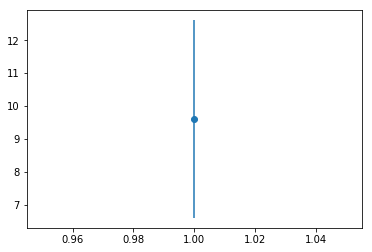

In [52]:
x = np.random.randint(5, 15, 15)
mean = np.mean(x)
std_deviation = np.std(x)
plt.errorbar(1, mean, yerr=std_deviation, fmt="o")
plt.ylim()[1]